###  AIML Online Capstone Project - AUTOMATIC TICKET ASSIGNMENT (Group 4)


#### Background :
In the support process, incoming incidents are analyzed and assessed by organization’s support teams to fulfill the request. 
Better allocation and effective usage of the valuable support resources will directly result in substantial cost savings. 
Currently, the incidents are created by various stakeholders and are assigned to L1/L2 teams.  
Incase L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from Applications and Infrastructure (L3 teams). 

#### Problem Statement :
L1 / L2 needs to spend time reviewing Standard Operating Procedures (SOPs) before assigning to Functional teams (Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket assignment). 
15 min is being spent for SOP review for each incident. Minimum of ~1 FTE effort needed only for incident assignment to L3 teams.
Multiple instances of incidents getting assigned to wrong functional groups (Around ~25%)
Additional effort needed for Functional teams to re-assign to right functional groups. 
During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service.!

#### Project Objectives :

Guided by powerful AI techniques 
* Classify incidents to right functional groups based on User description
* Help organizations to reduce the resolving time
* Improve productivity of Support teams

#### Data Pre-Processing
* This section of the Code deals with the Data Pre-Processing

In [185]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from langdetect import detect, detect_langs
import googletrans
from googletrans import Translator
import re
import translate
from tensorflow.keras.preprocessing.text import Tokenizer
#from googletranslate import Translator
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from string import digits
import string

In [186]:
import socket    
hostname = socket.gethostname()    
IPAddr = socket.gethostbyname(hostname)    
print("Your Computer Name is:" + hostname)    
print("Your Computer IP Address is:" + IPAddr) 

Your Computer Name is:Prasad-Dell-LT
Your Computer IP Address is:192.168.0.6


In [187]:
def remove_html(text):
  soup = BeautifulSoup(text,'lxml')
  html_free = soup.get_text()
  return html_free

def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

def remove_digits(list1): 
    remove_digits = str.maketrans('', '', digits) 
    list1 = [i.translate(remove_digits) for i in list1] 
    return list1

#### Use when running through google collab
from google.colab import drive
drive.mount('/drive', force_remount=True)

project_path = "/drive/My Drive/AIML_Project_Files_Final/10.Capstone Project"

In [188]:
# Please note that this Dataset has 4 more extra columns to identify the language and transilate to English
# Tried this transilation in Python using googletrans API but there is limitation on the numbers of calls, hence 
# googl sheets was used 
df = pd.read_excel("input_data_translated.xlsx", encoding="utf-8",dtype="str")

In [189]:
df.dtypes

Short description    object
Description          object
short_desc_lang      object
short_desc_en        object
description_lang     object
description_en       object
Caller               object
Assignment group     object
dtype: object

In [190]:
df.describe()

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group
count,8492,8499,8492,8492,8497,8497,8500,8500
unique,7481,7817,50,7379,36,7752,2950,74
top,password reset,the,en,password reset,en,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,7613,48,7768,56,810,3976


In [191]:
#Find the Null Values
print(df.isnull().sum())

Short description    8
Description          1
short_desc_lang      8
short_desc_en        8
description_lang     3
description_en       3
Caller               0
Assignment group     0
dtype: int64


In [192]:
# Since there are few records which are null, we decide to drop them 
df = df.dropna()

In [193]:
print(df.isnull().sum())

Short description    0
Description          0
short_desc_lang      0
short_desc_en        0
description_lang     0
description_en       0
Caller               0
Assignment group     0
dtype: int64


In [194]:
#Find and impute Null values from Short/long description 
print(df[pd.isnull(df["Short description"]) == True].index)
print(df[pd.isnull(df["Description"]) == True].index)


Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [195]:
# Load original dataset gven in the project 
df1 = pd.read_excel("input_data.xlsx")
df1.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [196]:
#Remove Junk charaters from the text.. below is an example
"ç­”å¤: ticket_no1559458 : wireless guest access- hr_tool trainer".encode('ascii','ignore').decode()

': ticket_no1559458 : wireless guest access- hr_tool trainer'

In [197]:
# We are going to use the DataFrame df for further processing 
df.describe()

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group
count,8489,8489,8489,8489,8489,8489,8489,8489
unique,7478,7810,50,7376,36,7747,2948,74
top,password reset,the,en,password reset,en,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,7610,48,7760,56,810,3966


In [198]:
# There is Email ID in the Description field . we need to saperate this and store in another column 
#RegEx to find email form the text .. an example below
emails = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][2])
print(emails)
my_str = "Hi my name is John and email address is john.doe@somecompany.co.uk and my friend's email is jane_doe124@gmail.com"
emails = re.findall("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)", my_str)
print(emails)


['eylqgodm.ybqkwiam@gmail.com']
['john.doe@somecompany.co.uk', 'jane_doe124@gmail.com']


In [199]:
#RegEx to remove spaces from the text.. an example below
t1 = '       Hello  World       From Pankaj \t\n\r\t \t /**  Hi There             '
print('Remove all spaces using RegEx:\n', re.sub(r"\s+", " ", df["Description"][2]), sep='')  # \s matches all white spaces

a = ' '.join([item for item in df["Description"][342].split() if '@' not in item])
b = re.sub(r"received from:","",a)

print(df["Short description"][223])
print (a,"  ",b)
#print(df["Description"][223])


Remove all spaces using RegEx:
 received from: eylqgodm.ybqkwiam@gmail.com hi i cannot log on to vpn best 
probleme mit bluescreen .
shortcut opening multiple folders    shortcut opening multiple folders


In [200]:
df.head(5)

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,en,login issue,en,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,en,outlook,en,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,en,cant log in to vpn,en,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,en,unable to access hr_tool page,en,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,en,skype error,en,skype error,owlgqjme qhcozdfx,GRP_0


In [201]:
#Find and impute Null values from Short description 
short_null = df[pd.isnull(df["Short description"]) == True].index
print(short_null)

Int64Index([], dtype='int64')


In [202]:
df.count()

Short description    8489
Description          8489
short_desc_lang      8489
short_desc_en        8489
description_lang     8489
description_en       8489
Caller               8489
Assignment group     8489
dtype: int64

In [203]:
# Remove the caller names form the description. This can be done by adding the users list to the stop words
users = list(df["Caller"])
users = np.hstack(np.unique(users))
stop_words1 = list(stop_words) + list(users)

In [204]:
# Process the Data and add new columns for analysis and data insights
df["emails"] = ""
df["email_type"]=""
df["short_desc_spl"] = ""
df["description_spl"] = ""
df["short_desc_len"] = ""
df["description_len"] = ""
df["no_of_splch_removed1"]=""
df["no_of_splch_removed1_pct"]=""
df["no_of_splch_removed2"]=""
df["no_of_splch_removed2_pct"]=""
df["short_desc_en_spl"] = ""
df["description_en_spl"] = ""
df["short_desc_en_len"] = ""
df["description_en_len"] = ""
df["trimmed_words"] = ""
df["trimmed_words_len"] = ""
df["trimmed_words_short"] = ""
df["trimmed_words_short_len"] = ""
df["trimmed_words_long"] = ""
df["trimmed_words_long_len"] = ""
df["mark_for_delete"]=0

x = 0
for i in tqdm(df.index):  
#_________________________________________________
  # Remove all the junk characters
  short_desc = str(df["Short description"][i]).encode('ascii','ignore').decode()
#_________________________________________________
#count no of spl characters removed and calacuate the percentage
      # Short description 
  df.loc[i,"no_of_splch_removed1"] = len(df["Short description"][i]) - len(str(df["Short description"][i]).encode('ascii','ignore').decode())
  if len(df["Short description"][i]) > 0 :
      df.loc[i,"no_of_splch_removed1_pct"] = np.round((df.loc[i,"no_of_splch_removed1"]*100 / len(df["Short description"][i])),1)
  else :
      df.loc[i,"no_of_splch_removed1_pct"] = 100
      # Description 
  desc = str(df["Description"][i]).encode('ascii','ignore').decode()
  df.loc[i,"no_of_splch_removed2"] = len(df["Description"][i]) - len(str(df["Description"][i]).encode('ascii','ignore').decode())
  
  if len(df["Description"][i]) >0 :
    df.loc[i,"no_of_splch_removed2_pct"] = np.round((df.loc[i,"no_of_splch_removed2"]*100 / len(df["Description"][i])),1)
  else :
    df.loc[i,"no_of_splch_removed2_pct"] = 100
#_________________________________________________
  # The below Funtion is to transilate the sentances to English but this free API has miliation. Hence not used. 
  # We used the pre transilated input data (using Googl sheet)
  #if b == "en" :
  #      trn = Translator().translate(short_desc, dest = "en", src = "auto")
  #      short_desc_en = trn.text 
  #      trn1 = Translator().translate(desc, dest = "en", src = "auto")
  #      Description_en = trn1.text
  #else :
  
  #The below function is to remove Junk Characters from text 
  short_desc_en = str(df["short_desc_en"][i]).encode('ascii','ignore').decode()
  Description_en =str(df["description_en"][i]).encode('ascii','ignore').decode()
  
  # Finding the first Email Address from the 'Description' column. 
  if(len(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][i]))) > 0:
      df.loc[i,"emails"] = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][i])[0]
    #df["emails"][i] = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][i])
  
  #Removing the Email ID from the short description ------------------------------------
  fltr_txt = ' '.join([item for item in short_desc.split() if '@' not in item])
  fltr_txt = re.sub(r"received from:","",fltr_txt)
  alpha = ""
  for char in fltr_txt:
    if char.isspace():
      alpha+= " "
    if char.isalnum():
      alpha+= char.lower()
  df.loc[i,"short_desc_spl"] = str(" ".join(alpha.split()))
  df.loc[i,"short_desc_len"] = len(alpha.split()) 
  #df.loc[i,"no_splch_removed"] = len(fltr_txt)-len(alpha.split())  
  #Removing the Email ID from the Description-------------------------------------------------
  fltr_txt1 = ' '.join([item for item in desc.split() if '@' not in item])
  fltr_txt1 = re.sub(r"received from:","",fltr_txt1)
  alpha1 = ""
  for char in fltr_txt1:
    if char.isspace():
      alpha1+= " "
    if char.isalnum():
      alpha1+= char.lower()
  df.loc[i,"description_spl"] = str(" ".join(alpha1.split()))
  df.loc[i,"description_len"] = len(alpha1.split())  
  #----------------------------   
  fltr_txt = ' '.join([item for item in short_desc_en.split() if '@' not in item])
  fltr_txt = re.sub(r"received from:","",fltr_txt)
  alpha = ""
  for char in fltr_txt:
    if char.isspace():
      alpha+= " "
    if char.isalnum():
      alpha+= char.lower()
  df.loc[i,"short_desc_en_spl"] = str(" ".join(alpha.split()))
  df.loc[i,"short_desc_en_len"] = len(alpha.split()) 
  #---------------------------------
  fltr_txt1 = ' '.join([item for item in Description_en.split() if '@' not in item])
  fltr_txt1 = re.sub(r"received from:","",fltr_txt1)
  alpha1 = ""
  for char in fltr_txt1:
    if char.isspace():
      alpha1+= " "
    if char.isalnum():
      alpha1+= char.lower()
  df.loc[i,"description_en_spl"] = str(" ".join(alpha1.split())) 
  df.loc[i,"description_en_len"] = len(alpha1.split())
  
  #--------------------------------------  
  # Final Text after stop word removal and combining both short and long description
  
  df.loc[i,"trimmed_words_short"] = " ".join([item for item in df["short_desc_en_spl"][i].split() if item not in stop_words1])
  df.loc[i,"trimmed_words_long"] = " ".join([item for item in df["description_en_spl"][i].split() if item not in stop_words1])

  if df["short_desc_en_spl"][i] == df["description_en_spl"][i] : 
    df.loc[i,"trimmed_words"] = " ".join([item for item in df["short_desc_en_spl"][i].split() if item not in stop_words1])
  else :
    df.loc[i,"trimmed_words"] = " ".join([item for item in df["short_desc_en_spl"][i].split() if item not in stop_words1])+" "+" ".join([item for item in df["description_en_spl"][i].split() if item not in stop_words1])
  #Mark records with lot of junk characters for  delete -----------------------------------------------
  df.loc[i,"trimmed_words_len"] = len(df["trimmed_words"][i].split())
  df.loc[i,"trimmed_words_short_len"] = len(df["trimmed_words_short"][i].split())
  df.loc[i,"trimmed_words_long_len"] = len(df["trimmed_words_long"][i].split())
  if df.loc[i,"trimmed_words_long_len"]==0 :
    df.loc[i,"trimmed_words_long"] = df["trimmed_words_short"][i] # If the Long description is empty, we copy the short description to Description
  if df.loc[i,"trimmed_words_short_len"]==0 :  
    df.loc[i,"mark_for_delete"]= 1 # if the short description is null, we better delete the record as copying the Description to short description will dilute the context
  if df["trimmed_words_len"][i] <= 1:
    df.loc[i,"mark_for_delete"]= 1
  if df["no_of_splch_removed1_pct"][i]>50: # sentances with more than 50% junk
    df.loc[i,"mark_for_delete"]= 1
  #if i in short_null :
  #  df.loc[i,"mark_for_delete"]= 1
  #Progress Bar-----------------------------------------------------------------------------------------------------------
  #if np.mod(i,1000) == 0:
    #print("\n")
  #  print(np.round((i*100/len(df))),"% ", end = "")
  #if np.mod(i,100) == 0:
  #  print("=", end = "")
  

100%|██████████| 8489/8489 [01:32<00:00, 91.79it/s] 


In [205]:
#Removing all the records marked for delete before further processing.....
df = df[df["mark_for_delete"]==0]
print(df.shape)

(8376, 29)


In [206]:
# Do further processing to remove digits, any htmltags, punctuation...etc
df['trimmed_words_short'] = remove_digits(df['trimmed_words_short'])
df['trimmed_words_long'] = remove_digits(df['trimmed_words_long'])
df['trimmed_words_short'] = df['trimmed_words_short'].apply(lambda x: remove_punctuation(x))
df['trimmed_words_long'] = df['trimmed_words_long'].apply(lambda x: remove_punctuation(x))
df['trimmed_words_short'] = df['trimmed_words_short'].apply(lambda x: remove_html(x))
df['trimmed_words_long'] = df['trimmed_words_long'].apply(lambda x: remove_html(x))
df.head(3)

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group,emails,email_type,...,description_en_spl,short_desc_en_len,description_en_len,trimmed_words,trimmed_words_len,trimmed_words_short,trimmed_words_short_len,trimmed_words_long,trimmed_words_long_len,mark_for_delete
0,login issue,-verified user details.(employee# & manager na...,en,login issue,en,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,,,...,verified user detailsemployee manager name che...,2,32,login issue verified user detailsemployee mana...,23,login issue,2,verified user detailsemployee manager name che...,21,0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,en,outlook,en,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,hmjdrvpb.komuaywn@gmail.com,,...,hello team my meetingsskype meetings etc are n...,1,22,outlook hello team meetingsskype meetings etc ...,14,outlook,1,hello team meetingsskype meetings etc appearin...,13,0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,en,cant log in to vpn,en,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,eylqgodm.ybqkwiam@gmail.com,,...,hi i cannot log on to vpn best,5,8,cant log vpn hi cannot log vpn best,8,cant log vpn,3,hi cannot log vpn best,5,0


In [207]:
# recalculate the length as the the above process might have removed some more chracters
df['trimmed_words_short_len'] = df['trimmed_words_short'].apply(lambda x: len(x.split()))
df['trimmed_words_long_len'] = df['trimmed_words_long'].apply(lambda x: len(x.split()))
df[df['trimmed_words_short_len']==0]

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group,emails,email_type,...,description_en_spl,short_desc_en_len,description_en_len,trimmed_words,trimmed_words_len,trimmed_words_short,trimmed_words_short_len,trimmed_words_long,trimmed_words_long_len,mark_for_delete
5464,ç­”å¤: 35969737/2032252,\r\n\r\nreceived from: wqzarvhx.hfsojckw@gmail...,no,"ç ""å¤: 35969737/2032252",en,\n\nreceived from: wqzarvhx.hfsojckw@gmail.com...,wqzarvhx hfsojckw,GRP_13,wqzarvhx.hfsojckw@gmail.com,,...,hi help pls check item 20 net value in conditi...,1,24,359697372032252 hi help pls check item 20 net ...,19,,0,hi help pls check item net value condition ta...,17,0
7843,dell 4 in 1,dell 4 in 1 adapter not working,it,of 4 in 1,en,dell 4 in 1 adapter not working,ntuhoafg bzwefjvk,GRP_19,,,...,dell 4 in 1 adapter not working,4,7,4 1 dell 4 1 adapter working,7,,0,dell adapter working,3,0


In [208]:
df[df['trimmed_words_long_len']==0]

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group,emails,email_type,...,description_en_spl,short_desc_en_len,description_en_len,trimmed_words,trimmed_words_len,trimmed_words_short,trimmed_words_short_len,trimmed_words_long,trimmed_words_long_len,mark_for_delete
6253,in the inbox always show there are several ema...,+86,en,in the inbox always show there are several ema...,und,86,mqbxwpfn uclrqfxa,GRP_0,,,...,86,18,1,inbox always show several emails read already 86,8,inbox always show several emails read already,7,,0,0


In [209]:
## Remove if there are still records where Short/Long description is null
df = df[df['trimmed_words_short_len']>0]
df = df[df['trimmed_words_long_len']>0]
print(df.shape)

(8373, 29)


In [210]:
df["trimmed_words_long"][0]

'verified user detailsemployee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved'

In [211]:
df["Description"][0]

'-verified user details.(employee# & manager name)\n-checked the user name in ad and reset the password.\n-advised the user to login and check.\n-caller confirmed that he was able to login.\n-issue resolved.'

In [212]:
#Word Tokenizer
numword = 2000
t = Tokenizer(num_words=numword)
t.fit_on_texts((df["short_desc_en_spl"]))
t1 = Tokenizer(num_words=numword)
t1.fit_on_texts((df["description_en_spl"]))


In [213]:
#build a word Corpus
short_desc_words = pd.DataFrame()
short_desc_words["word_index"] = ""
short_desc_words["word"] = ""
short_desc_words["word_count"] = ""

desc_words = pd.DataFrame()
desc_words["word_index"] = ""
desc_words["word"] = ""
desc_words["word_count"] = ""


i = 0
for word in tqdm(t.word_index):
    if not word in stop_words1:
        if i<= 1500 :
            new_row = {'word_index':t.word_index[word], 'word':word, 'word_count':t.word_counts[word]}
            short_desc_words = short_desc_words.append(new_row, ignore_index=True)
            i = i+1

        
i = 0
for word in tqdm(t1.word_index):
    if not word in stop_words1:
        if i<= 1500 :
            new_row = {'word_index':t1.word_index[word], 'word':word, 'word_count':t1.word_counts[word]}
            desc_words = desc_words.append(new_row, ignore_index=True)
            i = i+1


100%|██████████| 20352/20352 [00:04<00:00, 4331.09it/s]


In [214]:
short_desc_words

,word_index,word,word_count
0,5,job,978
1,7,jobscheduler,959
2,8,password,889
3,10,erp,850
4,11,failed,829
...,...,...,...
1496,1603,transactions,3
1497,1604,locations,3
1498,1607,bkwinsearchserverproddaily,3
1499,1608,various,3


In [215]:
desc_words

,word_index,word,word_count
0,9,please,2062
1,14,yesnona,1568
2,17,password,1204
3,20,user,1147
4,21,erp,1142
...,...,...,...
1496,1613,across,13
1497,1614,16,13
1498,1615,three,13
1499,1616,tries,13


In [216]:
short_desc_words.to_csv("short_desc_words.csv")
desc_words.to_csv("desc_words.csv")

In [217]:
df["flg_account_related"]=0
df["flg_crm"]=0
df["flg_engineering"]=0
df["flg_erp"]=0
df["flg_failed"]=0
df["flg_help"]=0
df["flg_install"]=0
df["flg_job"]=0
df["flg_laptop"]=0
df["flg_mobile"]=0
df["flg_network"]=0
df["flg_outlook"]=0
df["flg_printer"]=0
df["flg_skype"]=0
df["flg_ticket_update"]=0
df["flg_vpn"]=0
df["flg_windows"]=0
df["host_related"]=0
#df["mobile"]=0
df["blank_call"]=0
df["setup_ws"]=0

In [218]:

for i in tqdm(df.index):
#---------------------------------------------------------------------
    if df["emails"][i].find("gmail") >= 0:
        df.loc[i,"email_type"] = "gmail"
    else: 
        if df["emails"][i].find("monitoring_tool@") >=0:
            df.loc[i,"email_type"] = "monitoring_tool"
        else:
            if df["emails"][i].find("company") >=0:
                df.loc[i,"email_type"] = "company"
            else :
                df.loc[i,"email_type"] = "others"
    
    if df["trimmed_words"][i].find("access") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("account") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("locked") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("login") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("logon") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("password") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("passwordmanagementtool") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("passwords") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("reset") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("tologin") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("unlock") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("user") >= 0 :
        df.loc[i,"flg_account_related"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("circuit") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("connection") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("network") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("outage") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("server") >= 0 :
        df.loc[i,"flg_network"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("vpn") >= 0 :
        df.loc[i,"flg_vpn"] = 1
    if df["trimmed_words"][i].find("vpncompanycom") >= 0 :
        df.loc[i,"flg_vpn"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("computer") >= 0 :
        df.loc[i,"flg_laptop"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("crm") >= 0 :
        df.loc[i,"flg_crm"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("email") >= 0 :
        df.loc[i,"flg_outlook"] = 1
    if df["trimmed_words"][i].find("emails") >= 0 :
        df.loc[i,"flg_outlook"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("outlook") >= 0 :
        df.loc[i,"flg_outlook"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("error") >= 0 :
        df.loc[i,"flg_failed"] = 1
    if df["trimmed_words"][i].find("failed") >= 0 :
        df.loc[i,"flg_failed"] = 1
    if df["trimmed_words"][i].find("issue") >= 0 :
        df.loc[i,"flg_failed"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("engineering") >= 0 :
        df.loc[i,"flg_engineering"] = 1
    if df["trimmed_words"][i].find("engineeringtool") >= 0 :
        df.loc[i,"flg_engineering"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("erp") >= 0 :
        df.loc[i,"flg_erp"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("help") >= 0 :
        df.loc[i,"flg_help"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("install") >= 0 :
        df.loc[i,"flg_install"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("job") >= 0 :
        df.loc[i,"flg_job"] = 1
    if df["trimmed_words"][i].find("jobscheduler") >= 0 :
        df.loc[i,"flg_job"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("laptop") >= 0 :
        df.loc[i,"flg_laptop"] = 1
    if df["trimmed_words"][i].find("pc") >= 0 :
        df.loc[i,"flg_laptop"] = 1    
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("phone") >= 0 :
        df.loc[i,"flg_mobile"] = 1
    if df["trimmed_words"][i].find("telephonysoftware") >= 0 :
        df.loc[i,"flg_mobile"] = 1
    if df["trimmed_words"][i].find("mobile") >= 0 :
        df.loc[i,"flg_mobile"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("print") >= 0 :
        df.loc[i,"flg_printer"] = 1
    if df["trimmed_words"][i].find("printer") >= 0 :
        df.loc[i,"flg_printer"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("skype") >= 0 :
        df.loc[i,"flg_skype"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("problems") >= 0 :
        df.loc[i,"flg_failed"] = 1
    if df["trimmed_words"][i].find("unable") >= 0 :
        df.loc[i,"flg_failed"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("ticket") >= 0 :
        df.loc[i,"flg_ticket_update"] = 1
    if df["trimmed_words"][i].find("update") >= 0 :
        df.loc[i,"flg_ticket_update"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("windows") >= 0 :
        df.loc[i,"flg_windows"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("hostname") >= 0 :
        df.loc[i,"host_related"] = 1
#---------------------------------------------------------------------    
   
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("blank call") >= 0 :
        df.loc[i,"blank_call"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("setup new ws") >= 0 :
        df.loc[i,"setup_ws"] = 1
#---------------------------------------------------------------------    
    #if np.mod(i,1000) == 0:
     #print("\n")
    #  print(np.round((i*100/len(df))),"% ", end = "")
    #if np.mod(i,100) == 0:
    #  print("=", end = "")
  

100%|██████████| 8373/8373 [00:16<00:00, 521.13it/s]


In [219]:
df.dtypes

Short description           object
Description                 object
short_desc_lang             object
short_desc_en               object
description_lang            object
description_en              object
Caller                      object
Assignment group            object
emails                      object
email_type                  object
short_desc_spl              object
description_spl             object
short_desc_len              object
description_len             object
no_of_splch_removed1        object
no_of_splch_removed1_pct    object
no_of_splch_removed2        object
no_of_splch_removed2_pct    object
short_desc_en_spl           object
description_en_spl          object
short_desc_en_len           object
description_en_len          object
trimmed_words               object
trimmed_words_len           object
trimmed_words_short         object
trimmed_words_short_len      int64
trimmed_words_long          object
trimmed_words_long_len       int64
mark_for_delete     

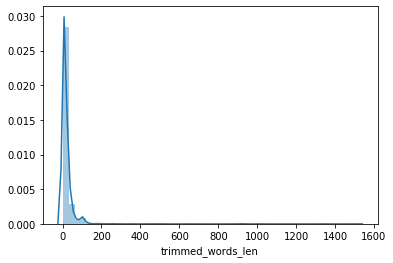

In [220]:
sns.distplot(df["trimmed_words_len"])

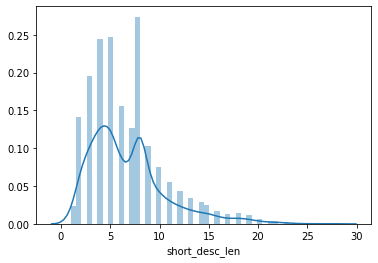

In [221]:
sns.distplot(df["short_desc_len"])

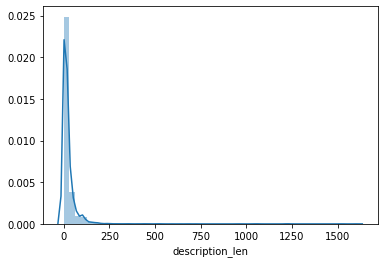

In [222]:
sns.distplot(df["description_len"])

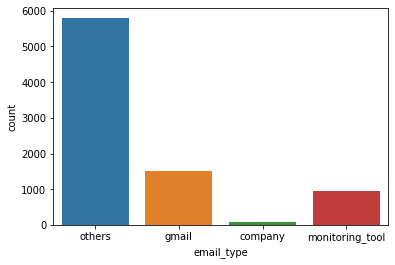

In [223]:
sns.countplot(df["email_type"])

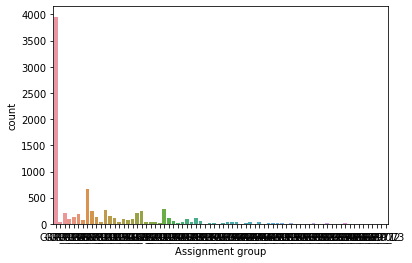

In [224]:
sns.countplot(df["Assignment group"])

In [225]:
# Analyze the assignment Groups by doing group by 
a = df.groupby("Assignment group")
a["Assignment group"].count().sort_values(ascending = False)

Assignment group
GRP_0     3954
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_61       1
GRP_67       1
GRP_35       1
GRP_73       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

In [226]:
#Anlyze the "short description"
b = df.groupby("Short description")
print(b["Short description"].count().sort_values(ascending = False).head(10))

Short description
password reset               38
windows password reset       29
account locked in ad         24
windows account locked       23
erp SID_34 account unlock    19
login issue                  18
account locked.              18
blank call                   18
unable to connect to vpn     18
erp SID_34 password reset    17
Name: Short description, dtype: int64


In [227]:
b = df.groupby("Caller")
print(b["Caller"].count().sort_values(ascending = False).head(10))

Caller
bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
jloygrwh acvztedi     64
spxqmiry zpwgoqju     63
oldrctiu bxurpsyi     57
olckhmvx pcqobjnd     53
jyoqwxhz clhxsoqy     51
Name: Caller, dtype: int64


In [228]:
#Check if there are still records marked for delete...
df[df["mark_for_delete"]==1][["Short description","Description","trimmed_words","description_en_len","description_en_spl","trimmed_words_len","no_of_splch_removed1","no_of_splch_removed1_pct","no_of_splch_removed2_pct"]]

,Short description,Description,trimmed_words,description_en_len,description_en_spl,trimmed_words_len,no_of_splch_removed1,no_of_splch_removed1_pct,no_of_splch_removed2_pct


In [229]:
#Export the processed Data for model building
df.to_excel("processed_data.xlsx")

## Summary of Columns : 

* Input file was loaded into a DataFrame. 
* It was observed that there are some records whcih are not in English. Tried to use googletran/ Transilator package in Python. However, they have limitation for no of free calls. Hence, loaded the data into google sheets and transilated
* In order to proces the data several new columns were created to undersatnd the no of special characters..etc
* Using tokenizer, word corpus was built with Max 1500 words. 
* Both short and long description was combined after removing special characters/ transilation to english/ applying Tokenizer
* Records where more than 50% characters are junk are marked for delete
* below is the list of new columns created


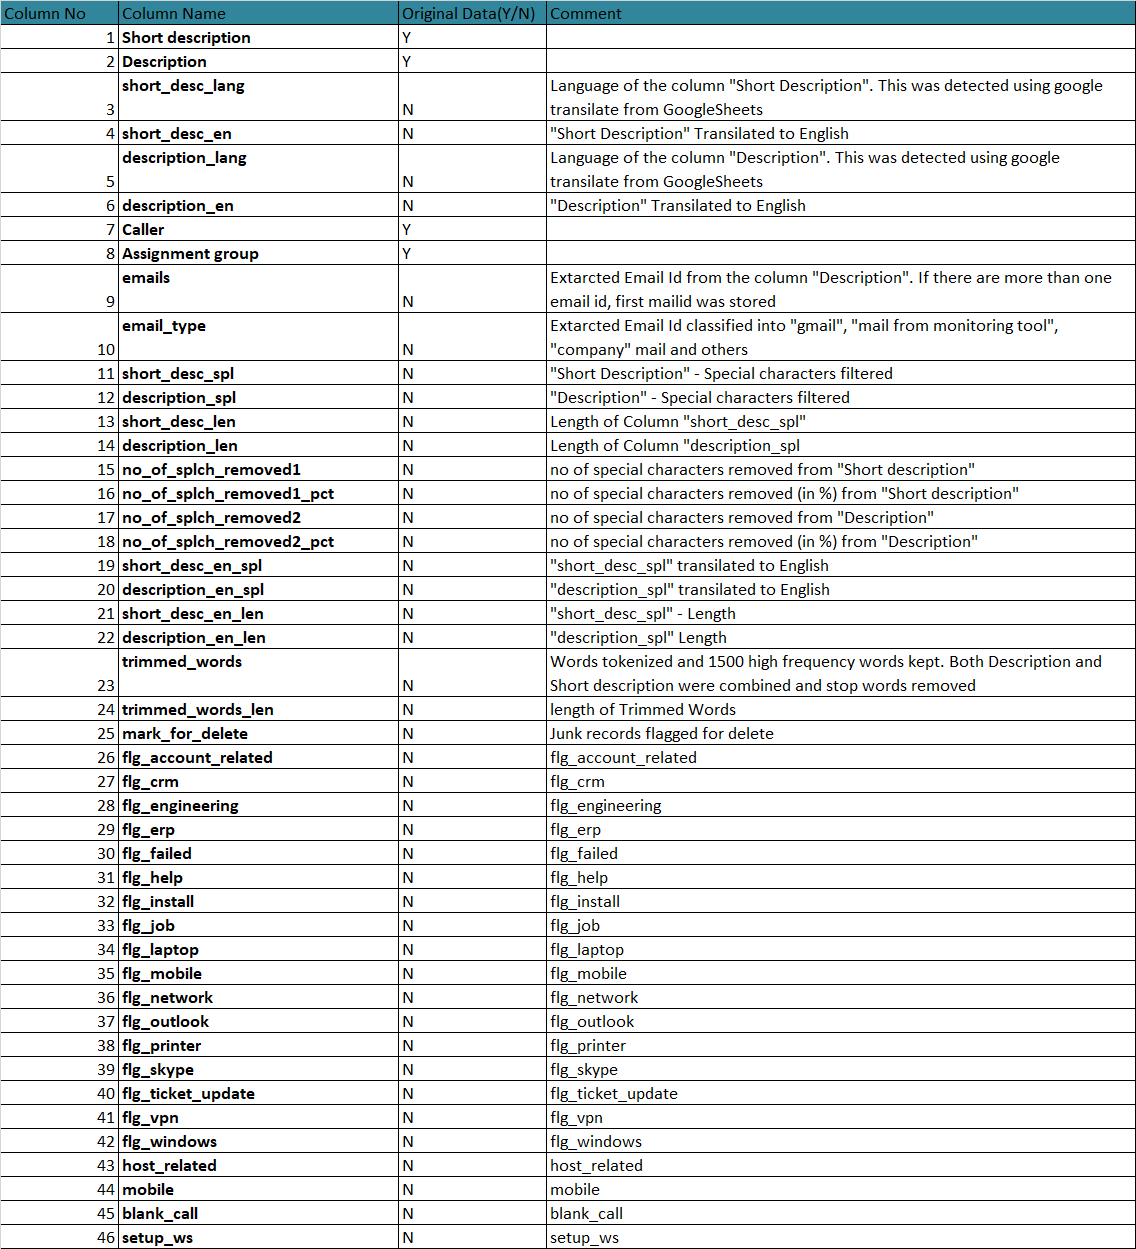


### Further processing 

Groups having less tickets should be combined as one group as we can not really make sence of them


In [230]:
# Dividing the Group by 75 - 25 %
a1 = df.groupby("Assignment group")["Assignment group"].count().sort_values(ascending = False)
thr = 75
print("Upto",thr,"% tickets Assignment Groups list :","\n ",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index)
new_group_75 = np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index
print("\n No of Selected groups : ",len(new_group_75), " out of ", len(a1), " total no of groups \n")
print("\n",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=101]*100/8500),2))

Upto 75 % tickets Assignment Groups list : 
  Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6'],
      dtype='object', name='Assignment group')

 No of Selected groups :  9  out of  74  total no of groups 


 Assignment group
GRP_0     46.52
GRP_8     54.29
GRP_24    57.69
GRP_12    60.72
GRP_9     63.68
          ...  
GRP_61    98.46
GRP_67    98.47
GRP_35    98.48
GRP_73    98.49
GRP_70    98.51
Name: Assignment group, Length: 74, dtype: float64


In [231]:
# Dividing the Group by 85 - 15 %

a1 = df.groupby("Assignment group")["Assignment group"].count().sort_values(ascending = False)
thr = 85
print("Upto",thr,"% tickets Assignment Groups list :","\n ",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index)
new_group_85 = np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index
print("\n No of Selected groups : ",len(new_group_85), " out of ", len(a1), " total no of groups \n")
print("\n",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=101]*100/8500),2))

Upto 85 % tickets Assignment Groups list : 
  Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29'],
      dtype='object', name='Assignment group')

 No of Selected groups :  17  out of  74  total no of groups 


 Assignment group
GRP_0     46.52
GRP_8     54.29
GRP_24    57.69
GRP_12    60.72
GRP_9     63.68
          ...  
GRP_61    98.46
GRP_67    98.47
GRP_35    98.48
GRP_73    98.49
GRP_70    98.51
Name: Assignment group, Length: 74, dtype: float64


In [232]:
# Dividing the Group by 95 - 5 %
a1 = df.groupby("Assignment group")["Assignment group"].count().sort_values(ascending = False)
thr = 95
print("Upto",thr,"% tickets Assignment Groups list :","\n ",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index)
new_group_95 = np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index
print("\n No of Selected groups : ",len(new_group_95), " out of ", len(a1), " total no of groups \n")
print("\n",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=101]*100/8500),2))

Upto 95 % tickets Assignment Groups list : 
  Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'GRP_16', 'GRP_17', 'GRP_7',
       'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41', 'GRP_15', 'GRP_42',
       'GRP_20', 'GRP_45', 'GRP_22', 'GRP_1', 'GRP_31', 'GRP_11', 'GRP_21'],
      dtype='object', name='Assignment group')

 No of Selected groups :  35  out of  74  total no of groups 


 Assignment group
GRP_0     46.52
GRP_8     54.29
GRP_24    57.69
GRP_12    60.72
GRP_9     63.68
          ...  
GRP_61    98.46
GRP_67    98.47
GRP_35    98.48
GRP_73    98.49
GRP_70    98.51
Name: Assignment group, Length: 74, dtype: float64


In [233]:
df["new_group_75"] = ""
df["new_group_85"] = ""
df["new_group_95"] = ""


for i in (df.index):
    if df["Assignment group"][i] in new_group_75:
        df.loc[i,"new_group_75"] = df["Assignment group"][i]
    else :
        df.loc[i,"new_group_75"] = "GRP_9999"
    
    if df["Assignment group"][i] in new_group_85:
        df.loc[i,"new_group_85"] = df["Assignment group"][i]
    else :
        df.loc[i,"new_group_85"] = "GRP_9999"
    
    if df["Assignment group"][i] in new_group_95:
        df.loc[i,"new_group_95"] = df["Assignment group"][i]
    else :
        df.loc[i,"new_group_95"] = "GRP_9999"
    
        

In [234]:
a = df.groupby("new_group_95")
a = pd.DataFrame(a["new_group_95"].count().sort_values(ascending = False))
print(a)

              new_group_95
new_group_95              
GRP_0                 3954
GRP_8                  661
GRP_9999               308
GRP_24                 289
GRP_12                 257
GRP_9                  252
GRP_2                  241
GRP_19                 213
GRP_3                  200
GRP_6                  184
GRP_13                 144
GRP_10                 139
GRP_5                  129
GRP_14                 118
GRP_25                 116
GRP_33                 106
GRP_4                  100
GRP_29                  96
GRP_18                  87
GRP_16                  85
GRP_17                  81
GRP_7                   68
GRP_34                  61
GRP_26                  56
GRP_40                  45
GRP_28                  44
GRP_41                  40
GRP_15                  39
GRP_42                  37
GRP_20                  36
GRP_45                  35
GRP_22                  31
GRP_1                   31
GRP_31                  31
GRP_11                  30
G

In [235]:
np.cumsum(a.new_group_95*100/8500)

new_group_95
GRP_0       46.517647
GRP_8       54.294118
GRP_9999    57.917647
GRP_24      61.317647
GRP_12      64.341176
GRP_9       67.305882
GRP_2       70.141176
GRP_19      72.647059
GRP_3       75.000000
GRP_6       77.164706
GRP_13      78.858824
GRP_10      80.494118
GRP_5       82.011765
GRP_14      83.400000
GRP_25      84.764706
GRP_33      86.011765
GRP_4       87.188235
GRP_29      88.317647
GRP_18      89.341176
GRP_16      90.341176
GRP_17      91.294118
GRP_7       92.094118
GRP_34      92.811765
GRP_26      93.470588
GRP_40      94.000000
GRP_28      94.517647
GRP_41      94.988235
GRP_15      95.447059
GRP_42      95.882353
GRP_20      96.305882
GRP_45      96.717647
GRP_22      97.082353
GRP_1       97.447059
GRP_31      97.811765
GRP_11      98.164706
GRP_21      98.505882
Name: new_group_95, dtype: float64

### Delete records marked for deletion


In [236]:
df_new = df[df["mark_for_delete"]==0]
print(df_new.shape)

(8373, 52)


In [237]:
len(df[df["mark_for_delete"]==1]["mark_for_delete"])

0

In [238]:
df_new.dtypes

Short description           object
Description                 object
short_desc_lang             object
short_desc_en               object
description_lang            object
description_en              object
Caller                      object
Assignment group            object
emails                      object
email_type                  object
short_desc_spl              object
description_spl             object
short_desc_len              object
description_len             object
no_of_splch_removed1        object
no_of_splch_removed1_pct    object
no_of_splch_removed2        object
no_of_splch_removed2_pct    object
short_desc_en_spl           object
description_en_spl          object
short_desc_en_len           object
description_en_len          object
trimmed_words               object
trimmed_words_len           object
trimmed_words_short         object
trimmed_words_short_len      int64
trimmed_words_long          object
trimmed_words_long_len       int64
mark_for_delete     

In [239]:
df_new_1 = pd.DataFrame(df_new[["trimmed_words_short","trimmed_words_long","Assignment group","new_group_75","new_group_85","new_group_95"]])

In [240]:
# New DataFrame Created for Model Building...
df_new.to_excel("processed_trimmed_data_all_columns.xlsx")
df_new_1.to_excel("processed_trimmed_data.xlsx")

In [241]:
X = df_new["trimmed_words_short"]
y = df_new["new_group_75"]

Review length: 
Mean 34.50 words (18.834306)


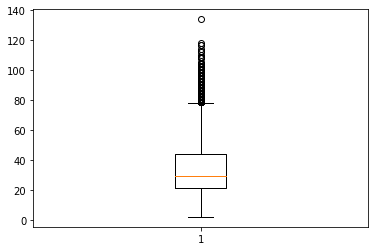

In [242]:
import numpy
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [243]:
X1 = t.texts_to_sequences(X)

In [244]:
X2 = pad_sequences(X1, maxlen=200, padding = 'post', truncating = 'post') 
#X_test =  pad_sequences(X_test, maxlen=100, padding = 'post', truncating = 'post')

In [245]:
X2.shape

(8373, 200)

In [246]:
X2[0]

array([21, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [247]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = df_new["new_group_75"]
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

In [248]:
label_encoder.classes_

array(['GRP_0', 'GRP_12', 'GRP_19', 'GRP_2', 'GRP_24', 'GRP_3', 'GRP_6',
       'GRP_8', 'GRP_9', 'GRP_9999'], dtype=object)

In [249]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [250]:
onehot_encoded.shape

(8373, 10)

In [251]:
integer_encoded.shape

(8373, 1)

In [252]:
y = onehot_encoded
print(y)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [253]:
#Import all the required Libraries

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Accuracy
import matplotlib.pyplot as plt
import collections
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add
from tensorflow.keras.models import Model, Sequential

%matplotlib inline

In [254]:
#Split the dataset into Train and test
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.2, random_state = 10, shuffle = True)
X_train.shape,y_train.shape, y_train[10], X_test.shape, y_test.shape

((6698, 200),
 (6698, 10),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 (1675, 200),
 (1675, 10))

In [255]:
batch_size = 100
epochs = 25

In [256]:
X2[0]

array([21, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 32)           19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 32)            0         
_________________________________________________________________
L2_LSTM (Bidirectional)      (None, 99, 256)           164864    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25344)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)              

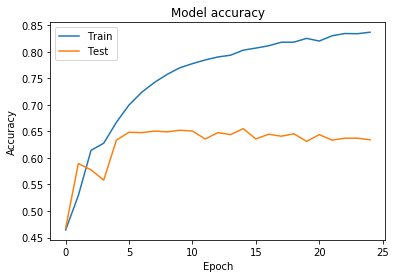

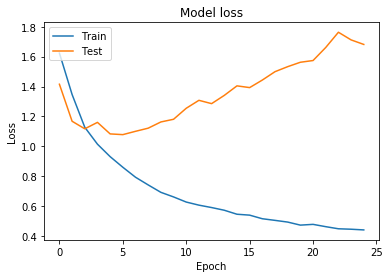

In [257]:
embedding_size = 200
maxlen = 200

# Crete a Sequential Model
model1 = Sequential()

# Add embedding as the first layer. We are going to initiate with the pre trained Glove vector. Since they are already trained embeddings
# We are going to make the trainable parameter 'false'
model1.add(Embedding(t.num_words, embedding_size, input_length = maxlen, trainable = True, name='L1_Embedding'))

#These embeddings are made non-trainable as they are pre trained to highly optimized values
model1.add(Conv1D(32,3,activation="relu"))
model1.add(MaxPooling1D(pool_size=2))

#Adding a Dropout ensures the model is not overfitting
model1.add(Dropout(0.5))

#Add Bi-Directional LSTM
model1.add(Bidirectional(LSTM(128, return_sequences = True, dropout = 0.2),name='L2_LSTM'))
model1.add(Flatten(name='L3_Flatten'))

# Add dense and Dropout 
model1.add(Dense(254, activation='relu',name='L4_Dense_relu'))
model1.add(Dropout(0.2, name  = "L5_Dropout"))

#Since this is a binary classification, we add the last layer as Dense with single neuron with Sigmoid. Based on the probability we can decide if the output is 0 or 1
model1.add(Dense(10, activation='sigmoid',name='L6_Dense_sigmoid'))

#Compile the model with binary cross entrophy and adam optimizer
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model1.summary()

# We are going to use validation split of 20%
history1 = model1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split = 0.2, verbose = 2)

#Predect on the test data
y_pred = model1.predict(X_test)
#y_pred = (y_pred>0.5).astype(np.int)

#print results
#print("\n","Confusion Matrix :","\n",confusion_matrix(y_test,y_pred))
#print("\n","Classification Report :","\n",classification_report(y_test,y_pred))

# Print plot of Training and Validation Accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Print plot of Training and Validation Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [258]:
X_test[0], y_test[0]

(array([  41,  498, 1510,   20,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [259]:
y_pred1 = np.zeros(shape = y_pred.shape)
for i in tqdm(range(len(y_pred1))):
    y_pred1[i][np.argmax(y_pred[i])]=1    

100%|██████████| 1675/1675 [00:00<00:00, 335056.24it/s]


In [260]:
y_pred1[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [261]:
print("\n","Classification Report :","\n",classification_report(y_test,y_pred1))


 Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       803
           1       0.50      0.40      0.44        53
           2       0.00      0.00      0.00        39
           3       0.57      0.39      0.47        51
           4       0.77      0.59      0.67        56
           5       0.15      0.11      0.13        37
           6       0.62      0.13      0.21        39
           7       0.51      0.89      0.64       134
           8       0.00      0.00      0.00        43
           9       0.58      0.60      0.59       420

   micro avg       0.67      0.67      0.67      1675
   macro avg       0.45      0.39      0.40      1675
weighted avg       0.65      0.67      0.65      1675
 samples avg       0.67      0.67      0.67      1675



C:\ProgramData\Anaconda3\envs\gpu_test\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [262]:
a_t = onehot_encoder.inverse_transform(y_test)
a_t1= onehot_encoder.inverse_transform(y_pred1)

In [263]:
print("\n","Confusion Matrix :","\n",confusion_matrix(a_t,a_t1))


 Confusion Matrix : 
 [[673   6   8   5   2   9   0   1   0  99]
 [  7  21   0   0   4   0   0   6   0  15]
 [ 20   1   0   1   1   3   0   0   0  13]
 [ 19   1   0  20   0   1   0   0   0  10]
 [ 13   1   2   0  33   2   0   1   0   4]
 [ 16   0   3   1   1   4   0   0   0  12]
 [  0   0   0   0   0   0   5  24   0  10]
 [  1   1   0   0   0   0   0 119   0  13]
 [  1   0   0   0   0   0   0  38   0   4]
 [ 91  11   2   8   2   7   3  46   0 250]]


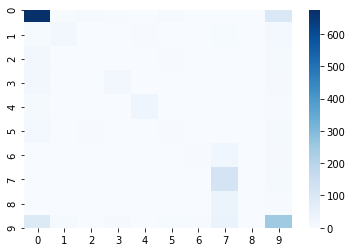

In [264]:
sns.heatmap(confusion_matrix(a_t,a_t1), cmap="Blues")